## Question 1. Fiscal Policy in HANK

Consider the very simple Heterogeneous Agent Model: 

\begin{align*}
\max_{c_{it}}\ &  \mathbb{E_0}\ \sum_{t=0}^\infty\ \beta^t\ \dfrac{c_{it}^{1-\sigma}}{1-\sigma} 
\\
c_{it} + a_{it} &= (1 + r_t)a_{it-1} + Z_t s_{it},
\\
a &\geq \underline{a}
\end{align*}

where $Z_t \equiv Y_t -T_t $ is the aggregate post-tax income. Market clearing: 

$$ 
Y_t = C_t + G_t
$$

and

$$ 
A_t \equiv \int a_{it} di = B_t
$$

This government budget constraint is:

$$
T_t = (1 + r_t) B_{t-1} + G_t - B_t.
$$

We will study the effect of different fiscal policy shocks. 



In [1]:
# ========================================================================= #
# ======= PACKAGES ======================================================== #
# ========================================================================= #

import numpy as np  # numpy helps us perform linear algebra calculations
import matplotlib.pyplot as plt  # helps us plot
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc

# Plot parameters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 12})

In [2]:
# ==================================================================== #
# ================== Block 1: Household Block ======================== #
# ==================================================================== #

hh = sj.hetblocks.hh_sim.hh
print(f'Inputs: {hh.inputs}\n') # simple household block  with inelastic labor supply 

make_grids = sj.hetblocks.hh_sim.make_grids # note that this function creates grids
#help(make_grids) # check the inputs of the function

# simple post-tax labor income
def income(Z, e_grid):
    y = Z * e_grid
    return y  

hh_extended = hh.add_hetinputs([make_grids, income]) # join the grid funtion together with HA block
print(hh_extended)
print('It has inputs: ' + str(hh_extended.inputs))
print('It has outputs: ' + str(hh_extended.outputs))



Inputs: ['a_grid', 'y', 'r', 'beta', 'eis', 'Pi']

<HetBlock 'hh' with hetinput 'make_grids_income'>
It has inputs: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Z']
It has outputs: ['A', 'C']


Next, we will specify two `SimpleBlock`s that will allow us to close our model: a fiscal policy (government) block and a market clearing block.

Here, we define the fiscal block in terms of government bonds `B`:

In [3]:
# ==================================================================== #
# ========= Block 2 and 3: MKT CLEARING AND GOVERNMENT =============== #
# ==================================================================== #

@sj.simple
def fiscal(B, r, G, Y):
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = ... # CHANGE HERE
    return asset_mkt, goods_mkt

Now we can put these `Block`s together to create a model!

In [4]:
ha = sj.create_model([hh_extended, fiscal, mkt_clearing], name="Simple HA Model")

print(ha)
print('It has inputs: ' + str(ha.inputs))
print('It has outputs: ' + str(ha.outputs))

<Model 'Simple HA Model'>
It has inputs: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'B', 'G', 'Y']
It has outputs: ['A', 'C', 'T', 'Z', 'deficit', 'asset_mkt', 'goods_mkt']


A model is really a `CombinedBlock`, which, like our $H$ function in lecture, itself has inputs and outputs.

Many of the inputs are model parameters, such as `eis`, `beta`, `rho_e`, etc. But some are actually aggregates we want to solve ("unknowns") for or shock ("exogenous inputs"). One nice feature in SSJ is that we don't have to distinguish the two at this point. This gives us flexibility to shock whatever we want later on.

Some of the outputs are "targets", such as `goods_mkt` or `asset_mkt`. By Walras' law, it is sufficient to impose either `asset_mkt` or `goods_mkt`.

Because we want to fix the steady state interest rate `r` at a pre-specified value, to satisfy 1) `asset_mkt`, we will calibrate `beta`. All the other parameters are below

In [5]:
# ==================================================================== #
# =========  Calibration ============================================= #
# ==================================================================== #

calibration = {'r' : 0.03, # Fixed interest rate
                'eis': 0.5,  # EIS
               'rho_e': 0.9,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,  # Standard deviation of idiosyncratic productivity shocks
               'G': 0.2,  # Government spending
               'B': 0.8,  # Government debt
               'Y': 1.,  # Output
               'min_a': 0.,  # Minimum asset level on the grid
               'max_a': 1_000,  # Maximum asset level on the grid
               'n_a': 200,  # Number of asset grid points
               'n_e': 10}  # Number of productivity grid points

In [6]:
# Find beta that get that interest rate
unknowns_ss = {'beta': (0.75, 0.9)}  # provide bounds on beta for the solver
targets_ss = ['asset_mkt']  # set the ss target

ss = ha.solve_steady_state(....)   # CHANGE HERE
ss.toplevel # This prints the calibration

{'r': 0.03,
 'eis': 0.5,
 'rho_e': 0.9,
 'sd_e': 0.92,
 'G': 0.2,
 'B': 0.8,
 'Y': 1.0,
 'min_a': 0.0,
 'max_a': 1000,
 'n_a': 200,
 'n_e': 10,
 'beta': 0.7971583864657364,
 'T': 0.22399999999999998,
 'Z': 0.776,
 'deficit': -0.023999999999999966,
 'A': 0.7999999999952183,
 'C': 0.7999999999707033,
 'asset_mkt': -4.781730567060549e-12,
 'goods_mkt': 2.9296731707262325e-11}

## Comparisons with RA and TA

We have to compare the propagation in HA with that in RA and TA models. To do so, we write `SimpleBlock`s that define the household problems for the representative and two-agent versions of the simple heterogeneous agent model we implemented above. What's nice is that we won't have to rewrite any other block!

In [7]:
@sj.solved(unknowns={'C': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # solver="broyden_custom")
def hh_ra(C, A, Z, eis, beta, r):
    euler = (beta * (1 + r(+1)))**(-eis) * C(+1) - C
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    return euler, budget_constraint

ra = sj.create_model([hh_ra, fiscal, mkt_clearing], name="Representative agent model")

@sj.solved(unknowns={'C_RA': 1, 'A': 1},
           targets=["euler", "budget_constraint"])  # , solver="broyden_custom")
def hh_ta(C_RA, A, Z, eis, beta, r, lam):
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA      # consumption of infinitely lived household
    C_H2M = Z   # computes consumption of an hand to mouth agent
    C = (1 - lam) * C_RA + lam * C_H2M   # aggregate consumption
    budget_constraint = (1 + r) * A(-1) + Z - C - A
    return euler, budget_constraint, C_H2M, C

ta = sj.create_model([hh_ta, fiscal, mkt_clearing], name="Two agent model")

One big problem we notice here already: When $\beta = 1/(1+r)$, neither `C` nor `A` are determined! This is because the model has an infinitely elastic steady state savings supply curve.
So in the steady state, we'll have to solve for `C` and `A` directly.

We redefine `beta` in the calibration, and match the same `B` that we had in the HA model. Finally we pin down `C`  and `A`  to be consistent with the budget constraint and asset market clearing. Using the `dissolve` keyword argument turns the `SolvedBlock`s into `SimpleBlock`s for the purpose of steady state evaluation, i.e. to "promote" `C`, `A` from being unknowns at their individual block level to the model level.

Calibrate both models:

In [9]:
# RA Model
calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 + calibration_ra['r'])
calibration_ra['B'] = ss['B']

unknowns_ra_ss = {'C': 1., 'A': 0.8}
targets_ra_ss = {'budget_constraint': 0., 'asset_mkt': 0.}
 
ss_ra = ra.solve_steady_state(... , dissolve=['hh_ra']) # CHANGE HERE

# TA Model
calibration_ta = calibration_ra.copy()
calibration_ta['lam'] = 0.25  # Calibration of TA
unknowns_ta_ss = {'C_RA': 1., 'A': 0.8}

ss_ta = ta.solve_steady_state(... , dissolve=['hh_ta'])  # CHANGE HERE

## Impulse response functions

Now that we have a steady state, let's compute some simple impulse responses

First, we will look at the response of output to a fully tax-financed increase in government spending of 1% of GDP, with persistence $\rho_G = 0.8$

In [10]:
T = 300  # <-- the length of the IRF
rho_G = 0.8
dG = 0.01 * rho_G ** np.arange(T)
shocks = {'G': dG}

What are the unknowns and targets we should specify to solve for this IRF? Let's investigate inputs and outputs of `ha` to figure this out.

The only unknown is `Y` here. We have two `target`s, but only need one, so let's use `asset_mkt` for now. (`goods_mkt` is similar.)

To do this, we call the `.solve_impulse_linear` method on the `ha` model object, providing as input arguments: `ss`, the list of unknowns, the list of targets, and the dict of shocks. You can inspect the contents of the returned `ImpulseDict` object, by indexing into it as you would a `dict` object.

In [11]:
print(ha.inputs)
print(ha.outputs)

unknowns_td = ['Y'] # You should change this...
targets_td = ['asset_mkt']  # You should change this...

irfs_ha = ha.solve_impulse_linear(... )  # CHANGE HERE

['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'B', 'G', 'Y']
['A', 'C', 'T', 'Z', 'deficit', 'asset_mkt', 'goods_mkt']


In [12]:
# Do the same for TA and RA model
irfs_ra = ra.solve_impulse_linear(... ) # CHANGE HERE
irfs_ta = ta.solve_impulse_linear(... ) # CHANGE HERE

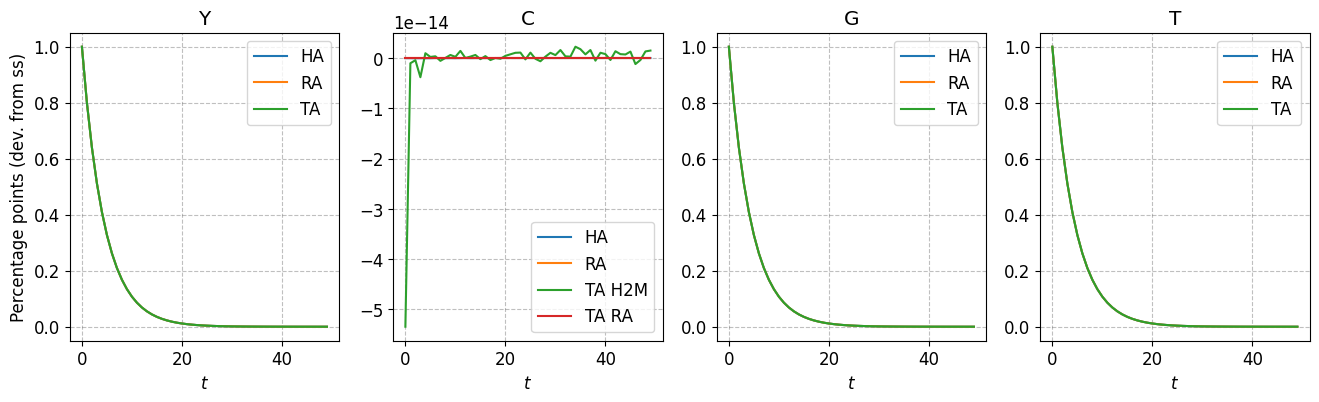

In [13]:
# Plot the IRF of the interest rate shocks in both models:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True)
ax[0].plot(100 * irfs_ha['Y'][:50], label="HA")
ax[0].plot(100 * irfs_ra['Y'][:50], label="RA")
ax[0].plot(100 * irfs_ta['Y'][:50], label="TA")
ax[0].set_title('Y')
ax[0].set_xlabel(r"$t$")
ax[0].legend()
ax[0].set_ylabel("Percentage points (dev. from ss)")

ax[1].plot(100 * irfs_ha['C'][:50], label="HA")
ax[1].plot(100 * irfs_ra['C'][:50], label="RA")
ax[1].plot(100 * irfs_ta['C_H2M'][:50], label="TA H2M")
ax[1].plot(100 * irfs_ta['C_RA'][:50], label="TA RA")
ax[1].set_title('C')
ax[1].set_xlabel(r"$t$")
ax[1].legend()

ax[2].plot(100 * irfs_ha['G'][:50], label="HA")
ax[2].plot(100 * irfs_ra['G'][:50], label="RA")
ax[2].plot(100 * irfs_ta['G'][:50], label="TA")
ax[2].set_title('G')
ax[2].set_xlabel(r"$t$")
ax[2].legend()

ax[3].plot(100 * irfs_ha['T'][:50], label="HA")
ax[3].plot(100 * irfs_ra['T'][:50], label="RA")
ax[3].plot(100 * irfs_ta['T'][:50], label="TA")
ax[3].set_title('T')
ax[3].set_xlabel(r"$t$")
ax[3].legend()

plt.show()

## Debt Financed Fiscal Policy Shock

What if we want to make the increase in `G` entirely debt financed initially?

This means we need to feed in a simultaneous shock to `B`, that initially increases by the same amount as `G`. 

In [14]:
rho_B = 0.5 # low persistence shock
dB = np.cumsum(dG) * rho_B ** np.arange(T) # Note the cumsum! The fiscal shock accumulates.
shocks_B_low = {'G': dG, 'B': dB}

irfs_ha_B_low = ha.solve_impulse_linear(... ) # CHANGE HERE

rho_B = 0.9 # high persistence shock
dB = np.cumsum(dG) * rho_B ** np.arange(T) 
shocks_B = {'G': dG, 'B': dB}

irfs_ha_B = ha.solve_impulse_linear( .... ) # CHANGE HERE


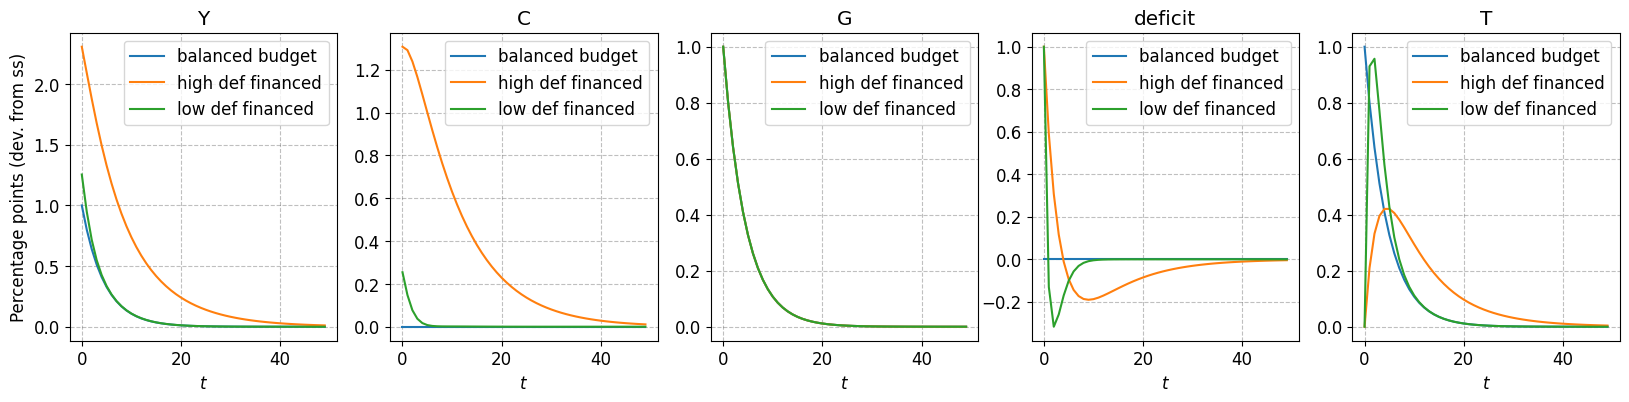

In [92]:
# Plot the IRF of the fiscal policy shocks:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharex=True)
ax[0].plot(100 * irfs_ha['Y'][:50], label="balanced budget")
ax[0].plot(100 * irfs_ha_B['Y'][:50], label="high def financed")
ax[0].plot(100 * irfs_ha_B_low['Y'][:50], label="low def financed")
ax[0].set_title('Y')
ax[0].set_xlabel(r"$t$")
ax[0].legend()
ax[0].set_ylabel("Percentage points (dev. from ss)")

ax[1].plot(100 * irfs_ha['C'][:50], label="balanced budget")
ax[1].plot(100 * irfs_ha_B['C'][:50], label="high def financed")
ax[1].plot(100 * irfs_ha_B_low['C'][:50], label="low def financed")
ax[1].set_title('C')
ax[1].set_xlabel(r"$t$")
ax[1].legend()

ax[2].plot(100 * irfs_ha['G'][:50], label="balanced budget")
ax[2].plot(100 * irfs_ha_B['G'][:50], label="high def financed")
ax[2].plot(100 * irfs_ha_B_low['G'][:50], label="low def financed")
ax[2].set_title('G')
ax[2].set_xlabel(r"$t$")
ax[2].legend()

ax[3].plot(100 * irfs_ha['deficit'][:50], label="balanced budget")
ax[3].plot(100 * irfs_ha_B['deficit'][:50], label="high def financed")
ax[3].plot(100 * irfs_ha_B_low['deficit'][:50], label="low def financed")
ax[3].set_title('deficit')
ax[3].set_xlabel(r"$t$")
ax[3].legend()

ax[4].plot(100 * irfs_ha['T'][:50], label="balanced budget")
ax[4].plot(100 * irfs_ha_B['T'][:50], label="high def financed")
ax[4].plot(100 * irfs_ha_B_low['T'][:50], label="low def financed")
ax[4].set_title('T')
ax[4].set_xlabel(r"$t$")
ax[4].legend()

plt.show()

In [15]:
# Compute the IRF: RA and TA model:

irfs_ra = ra.solve_impulse_linear( ... )  # CHANGE HERE 
irfs_ta_low = ta.solve_impulse_linear( ... )  # CHANGE HERE 



In [16]:
# Define the TANK model with high share of H2M agents...
calibration_ta['lam'] = 0.75  # Calibration of TA
unknowns_ta_ss = {'C_RA': 1., 'A': 0.8}

ss_ta = ta.solve_steady_state( ... , dissolve=['hh_ta']) # CHANGE HERE 

irfs_ta_high = ta.solve_impulse_linear(... )  # CHANGE HERE 


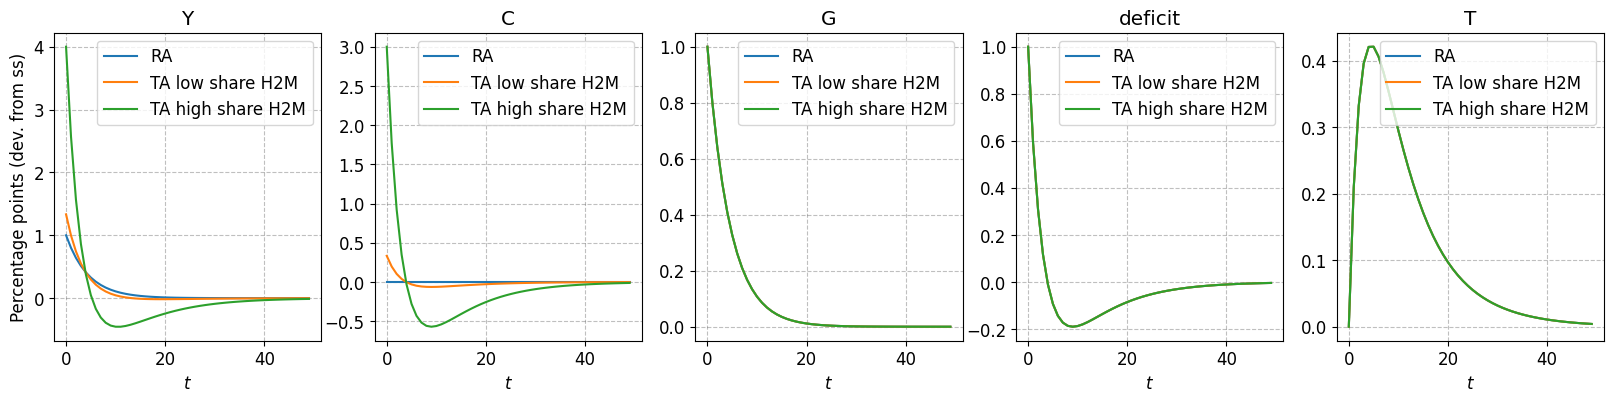

In [17]:
# Plot the IRF of the fiscal policy shocks:
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharex=True)
ax[0].plot(100 * irfs_ra['Y'][:50], label="RA")
ax[0].plot(100 * irfs_ta_low['Y'][:50], label="TA low share H2M")
ax[0].plot(100 * irfs_ta_high['Y'][:50], label="TA high share H2M")
ax[0].set_title('Y')
ax[0].set_xlabel(r"$t$")
ax[0].legend()
ax[0].set_ylabel("Percentage points (dev. from ss)")

ax[1].plot(100 * irfs_ra['C'][:50], label="RA")
ax[1].plot(100 * irfs_ta_low['C'][:50], label="TA low share H2M")
ax[1].plot(100 * irfs_ta_high['C'][:50], label="TA high share H2M")
ax[1].set_title('C')
ax[1].set_xlabel(r"$t$")
ax[1].legend()

ax[2].plot(100 * irfs_ra['G'][:50], label="RA")
ax[2].plot(100 * irfs_ta_low['G'][:50], label="TA low share H2M")
ax[2].plot(100 * irfs_ta_high['G'][:50], label="TA high share H2M")
ax[2].set_title('G')
ax[2].set_xlabel(r"$t$")
ax[2].legend()

ax[3].plot(100 * irfs_ra['deficit'][:50], label="RA")
ax[3].plot(100 * irfs_ta_low['deficit'][:50], label="TA low share H2M")
ax[3].plot(100 * irfs_ta_high['deficit'][:50], label="TA high share H2M")
ax[3].set_title('deficit')
ax[3].set_xlabel(r"$t$")
ax[3].legend()

ax[4].plot(100 * irfs_ra['T'][:50], label="RA")
ax[4].plot(100 * irfs_ta_low['T'][:50], label="TA low share H2M")
ax[4].plot(100 * irfs_ta_high['T'][:50], label="TA high share H2M")
ax[4].set_title('T')
ax[4].set_xlabel(r"$t$")
ax[4].legend()

plt.show()

## Question 2. Direct vs Indirect Effects of Monetary Policy

Consider the very simple Heterogeneous Agent Model: 

\begin{align*}
\max_{c_{it}}\ &  \mathbb{E_0}\ \sum_{t=0}^\infty\ \beta^t\ \dfrac{c_{it}^{1-\sigma}}{1-\sigma} 
\\
c_{it} + a_{it} &= (1 + r_t)a_{it-1} + Y_t s_{it} 
\\
a &\geq \underline{a}
\end{align*}

with market clearing: 

$$ 
C_t \equiv \int c_{it} di = Y_t
$$

and

$$ 
A_t \equiv \int a_{it} di = 0
$$

This implies the following fixed point:

$$
\mathcal{C}_t(\{r_s, Y_s\}) = Y_t.
$$

We will consider a "demand-driven" (as if prices were fully fixed). In this case, a shock in the sequence of interest rate $\{r_s\}$ will require a change in aggregate output $Y_t$.

As in the IKC model, the linearized response of output implies:

$$
d \mathbb{Y} = \underbrace{\mathbb{M}^r d \mathbb{r}}_{\text{direct effects}} + \underbrace{\mathbb{M} d \mathbb{Y}}_{\text{indirect effects}},
$$

where $\mathbb{M}^r \equiv \partial \mathcal{C}_t / \partial r_s $ is the jacobian capturing the direct effect of the interest rate on $\mathcal{C}$.

Let's decompose the direct and indirect effect of a shock in $r$ in different models: HA and RA.


In [18]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import sequence_jacobian as sj


Let's first define our simple heterogeneous agent model. We will use the hetblock and the make grids pre-build functions. 

In [19]:
# ==================================================================== #
# ================== Block 1: Household Block ======================== #
# ==================================================================== #

hh = sj.hetblocks.hh_sim.hh
print(f'Inputs: {hh.inputs}\n') # simple household block  with inelastic labor supply 

make_grids = sj.hetblocks.hh_sim.make_grids # note that this function creates grids
#help(make_grids) # check the inputs of the function

# simple post-tax labor income
def income(Y, e_grid):
    y = Y * e_grid
    return y

household_simple = hh.add_hetinputs([make_grids, income])
#print(household_simple.inputs) 
#print('Micro outputs: ', hh.internals)
#print('Outputs: ', hh.outputs)

Inputs: ['a_grid', 'y', 'r', 'beta', 'eis', 'Pi']




In addition, we have the usual market clearing block.

In [20]:
# ==================================================================== #
# =============== Block 2: Market Clearing Block ===================== #
# ==================================================================== #

@sj.simple
def mkt_clearing_simple(A, Y, C):
    asset_mkt = A
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

# ==================================================================== #
# =============== Define the model  ================================== #
# ==================================================================== #
ha_simple = sj.create_model([household_simple, mkt_clearing_simple])
print('Inputs:', ha_simple.inputs)
print('Outputs:', ha_simple.outputs)

Inputs: ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'Y']
Outputs: ['A', 'C', 'asset_mkt', 'goods_mkt']


Note we fix the interest rate and output in the steady state and calibrate $\beta$ to get asset market clearing. 

In [21]:
calibration = {'eis': 0.5,     # EIS
               'rho_e': 0.92,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,   # Standard deviation of idiosyncratic productivity shocks
               'Y': 1.,        # Output
               'r': 0.01,     # target real interest rate
               'min_a': -1,    # Minimum asset level on the grid
               'max_a': 1_000, # Maximum asset level on the grid
               'n_a': 500,     # Number of asset grid points
               'n_e': 11}      # Number of productivity grid points

# Note that we are fixing Y and choosing Beta such that the asset market clears
unknowns_ss = {'beta': (0.75, 0.9)}  # provide bounds on beta for the solver
targets_ss = ['asset_mkt']  # set the ss target


ss_ha = ha_simple.solve_steady_state(...) # CHANGE HERE 
ss_ha.toplevel # This prints the calibration

{'eis': 0.5,
 'rho_e': 0.92,
 'sd_e': 0.92,
 'Y': 1.0,
 'r': 0.01,
 'min_a': -1,
 'max_a': 1000,
 'n_a': 500,
 'n_e': 11,
 'beta': 0.823354842513158,
 'A': 6.556095943910378e-12,
 'C': 1.0000000000007718,
 'asset_mkt': 6.556095943910378e-12,
 'goods_mkt': 7.718270467194088e-13}

Now, construct The RA version of our simple model. We write everything in the models dictionary "models", as well as their steady state. 

In [22]:
# ==================================================================== #
# =============== Representative Agent Model  ======================== #
# ==================================================================== #

# Solved model are mini models inside a larger model
@sj.solved(unknowns={'C': 1, 'A': 1}, targets=["euler", "budget_constraint"], solver="broyden_custom")
def household_ra_simple(C, A, Y, eis, beta, r):
    euler = (beta * (1 + r(1))) ** (-eis) * C(1) - C
    budget_constraint = (1 + r) * A(-1) + Y - C - A
    return euler, budget_constraint

ra_model = sj.create_model([household_ra_simple, mkt_clearing_simple], name="Representative Agent Model")

calibration_ra = calibration.copy()
calibration_ra['beta'] = 1 / (1 + calibration_ra['r']) # Different interest rate
ss_ra = ra_model.solve_steady_state(calibration_ra, {'C': 1., 'A': 0.8}, {'budget_constraint': 0., 'asset_mkt': 0.},
                                           dissolve=['household_ra_simple'])

print(r'Beta in the HA model:', ss_ha['beta'], ' ; Beta in the RA model: ', ss_ra['beta'])

Beta in the HA model: 0.823354842513158  ; Beta in the RA model:  0.9900990099009901


We are going to use the method "solve_impulse_linear". This method solve for the IRF for all output variables. It is much more convenient than solve one-by-one (albeit slower).

In [23]:
# The function takes a SS of a model, a list of unknowns, a list of targets, and inputs
help(ha_simple.solve_impulse_linear)


Help on method solve_impulse_linear in module sequence_jacobian.blocks.block:

solve_impulse_linear(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, unknowns: List[str], targets: List[str], inputs: Union[Dict[str, Any], sequence_jacobian.classes.impulse_dict.ImpulseDict], outputs: Optional[List[str]] = None, Js: Optional[Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict]] = {}, options: Dict[str, dict] = {}, H_U_factored: Optional[sequence_jacobian.classes.jacobian_dict.FactoredJacobianDict] = None, **kwargs) -> sequence_jacobian.classes.impulse_dict.ImpulseDict method of sequence_jacobian.blocks.combined_block.CombinedBlock instance
    Calculate a general equilibrium, linear impulse response to a set of shocks in `inputs`
    around a steady state `ss`, given a set of `unknowns` and `targets` corresponding to the endogenous
    variables to be solved for and the target conditions that must hold in general equilibrium



In [25]:
# ========= Find the linear impulse responses to an "r" shock
T = 300
dr = -0.01 * 0.7 ** np.arange(T) # This is the shock
shock_r = {'r': dr}
# HINT: in our model the unknown is Y and the target is asset_mkt
unknown = ['Y']
target = ['asset_mkt']


# First, the IRF of the HA model:
ha_irf = ha_simple.solve_impulse_linear(...)  # CHANGE HERE 

# Second, the IRF of the RA model:
ra_irf = ra_model.solve_impulse_linear(...)  # CHANGE HERE 

print("Dictionary of IRF of a model: ", ha_irf)
#print('\nIRF of HA model:\n', ha_irf['Y'])

Dictionary of IRF of a model:  <ImpulseDict: ['r', 'Y', 'A', 'C', 'asset_mkt', 'goods_mkt']>


Now we are ready to look at the response of output to a decrease in the interest rate, with a per-period persistence of $0.7$.

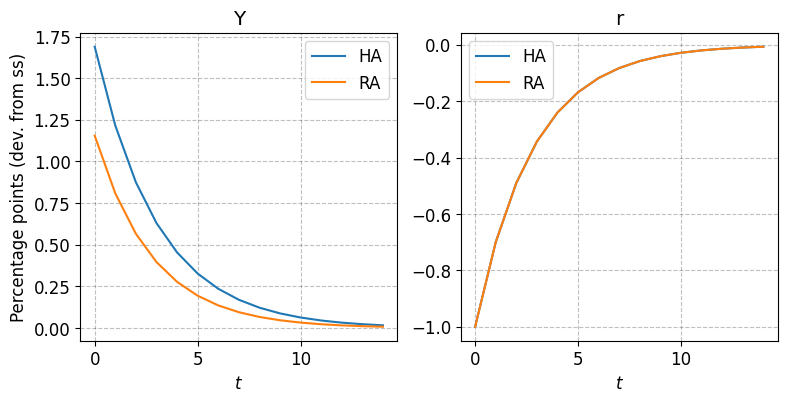

In [8]:
# Plot the IRF of the interest rate shocks in both models:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
ax[0].plot(100 * ha_irf['Y'][:15], label="HA")
ax[0].plot(100 * ra_irf['Y'][:15], label="RA")
ax[0].set_title('Y')
ax[0].set_xlabel(r"$t$")
ax[0].legend()
ax[0].set_ylabel("Percentage points (dev. from ss)")

ax[1].plot(100 * ha_irf['r'][:15], label="HA")
ax[1].plot(100 * ra_irf['r'][:15], label="RA")
ax[1].set_title('r')
ax[1].set_xlabel(r"$t$")
ax[1].legend()

plt.show()



The baseline HA economy  has a higher output response to the interest rate shock! The RA is exactly the same as the HA with zero liquidity. 

Why? 
Recall that in a credit economy with zero liquidity all agents have $a = 0$ in equilibrium. This means that they behave just like a RA economy where the RA holds 0 net assets. Ivan Werning emphasize this result in his 2015 working paper version. Recall we have acyclical income risk, this will be important as we show later. 

To understand the higher output response in HA economies, recall that the linearized response of output implies:

$$
d \mathbb{Y} = \underbrace{\mathbb{M}^r d \mathbb{r}}_{\text{direct effects}} + \underbrace{\mathbb{M} d \mathbb{Y}}_{\text{indirect effects}}.
$$

Abusing the notation, particularly assuming some regularity conditions in $\mathbb{M}$, we have:

$$
d \mathbb{Y} =  (\mathbb{I} - \mathbb{M})^{-1} \mathbb{M}^r d \mathbb{r}.
$$

So the response depends on both $\mathbb{M}$ and $\mathbb{M}^r$.

We will now inspect the "direct" and "indirect effect" of the interest rate shock.

In [26]:
help(ha_simple['hh'].jacobian)

Help on method jacobian in module sequence_jacobian.blocks.block:

jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, inputs: List[str], outputs: Optional[List[str]] = None, T: Optional[int] = None, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.het_block.HetBlock instance
    Calculate a partial equilibrium Jacobian to a set of `input` shocks at a steady state `ss`.



Here we see that `.jacobian` takes arguments (in order):
1. `SteadyStateDict` (the output of a call to `.steady_state`, or `.solve_steady_state`),
2. a `list` of inputs the user wants to calculate the Jacobian with respect to

Now we're ready to calculate the direct effect of a change in the interest rate on consumption. 

Note that,going from the primitive `r` to the household block requires first going through the `ex_post_rate` block to get the ex-post rate from the ex-ante rate. What we really want is this combined Jacobian.

A simple way to do this is to form a `CombinedBlock`.

We can now take the Jacobian of this block with respect to its two inputs `Y` and `r_ante`.

In [27]:
help(ha_simple['hh'].jacobian)
J = ha_simple['hh'].jacobian(ss_ha, inputs=['Y', 'r'], T=T)
print(J)

Help on method jacobian in module sequence_jacobian.blocks.block:

jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, inputs: List[str], outputs: Optional[List[str]] = None, T: Optional[int] = None, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.het_block.HetBlock instance
    Calculate a partial equilibrium Jacobian to a set of `input` shocks at a steady state `ss`.

<JacobianDict outputs=['A', 'C'], inputs=['Y', 'r']>


Vizualizing the Consumption jacobians:

In [28]:
col_list = [0, 5, 10, 15, 20]
J_cols = [{'Y':J['C']['Y'][:, i], 'r':J['C']['r'][:, i]} 
          for i in col_list]


col_list = [0, 5, 10, 15, 20]
J_cols = [{'Y':J['C']['Y'][:, i], 'r':J['C']['r'][:, i]} \
          for i in col_list]

We can use these Jacobians to get he direct/indirect decomposition. 

In [29]:
dC, dC_dr, dC_dY = {}, {}, {}  # we include that in dictionaries since we will also do for the RA model.
dC['ha'] = ha_irf['C']   # Total Effect
dC_dr['ha'] = ...  @ dr          # Direct Effect   # CHANGE HERE You should write a Jacobian 
dC_dY['ha'] = J['C']['Y'] @ dC['ha']     # Indirect Effect  



Note that the total effect is the sum of both the direct and indirect. 
Let's test if they are actually the same:

In [30]:
np.allclose(dC_dr['ha']+dC_dY['ha'], dC['ha'])

True

Now, we'll redo the same calculations in the RA model, and then compare the direct/indirect decomposition in both models. 

In [32]:
# Re-do the same calculations for the RA model
dC['ra'] = ra_irf['C']

beta = calibration_ra['beta']
Mra = (1 - beta) * beta ** (np.tile(np.arange(T), (T, 1))) # recall that M in the representative agent is represent like this (see IKC paper)
dC_dY['ra'] = Mra @ dC['ra']       
dC_dr['ra'] = dC['ra'] - dC_dY['ra']  

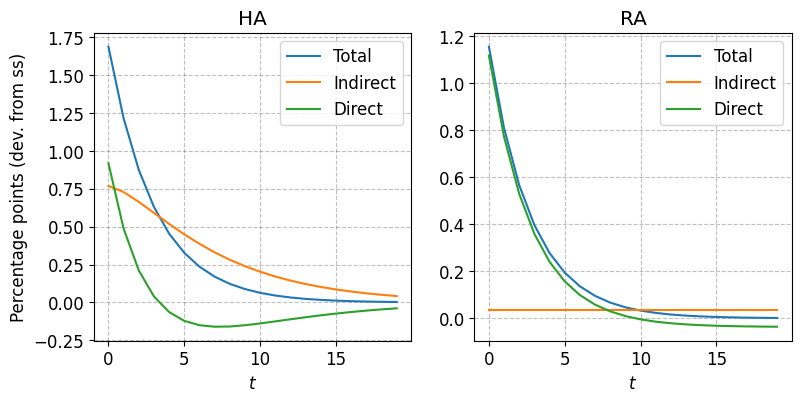

In [33]:
# Plot the IRF of the interest rate shocks in both models:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
ax[0].plot(100 * dC['ha'][:20], label="Total")
ax[0].plot(100 * dC_dY['ha'][:20], label="Indirect")
ax[0].plot(100 * dC_dr['ha'][:20], label="Direct")
ax[0].set_title('HA')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel("Percentage points (dev. from ss)")
ax[0].legend()

ax[1].plot(100 * dC['ra'][:20], label="Total")
ax[1].plot(100 * dC_dY['ra'][:20], label="Indirect")
ax[1].plot(100 * dC_dr['ra'][:20], label="Direct")
ax[1].set_title('RA')
ax[1].set_xlabel(r"$t$")
ax[1].legend()

plt.show()


This was just like Kaplan-Moll-Violante. Heterogeneity reduces the direct effect (sensitivity of interest rate changes), but increases the indirect effect! 